In [1]:
import argparse
import shutil
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import json

from sklearn.model_selection import train_test_split

In [2]:
size_x = 384
size_y = 480

In [3]:
def rle2mask(src_string: str, size: tuple) -> np.array:
   
    width, height = size

    mark = np.zeros(width * height).astype(np.uint8)

    array = np.asarray([int(x) for x in src_string.split()])
    starts = array[0::2]
    ends = array[1::2]

    current_position = 0
    for index, first in enumerate(starts):
        mark[int(first) : int(first + ends[index])] = 1
        current_position += ends[index]

    return mark.reshape(width, height).T

In [4]:
Path("data/train_images").mkdir(parents=True, exist_ok=True)
Path("data/train_labels").mkdir(parents=True, exist_ok=True)

Path("data/valid_images").mkdir(parents=True, exist_ok=True)
Path("data/valid_labels").mkdir(parents=True, exist_ok=True)

Path("data/test_images").mkdir(parents=True, exist_ok=True)
Path("data/test_labels").mkdir(parents=True, exist_ok=True)

In [5]:
df = pd.read_csv('data/train.csv')
df = df[df.ClassId.str.len() <= 2]
df.ClassId = df.ClassId.astype(int)

In [6]:
f = open('data/label_descriptions.json',)
mapper = json.load(f)
mapper = pd.DataFrame([[i['id'], i['name']] for i in mapper['categories']], columns=['ClassId', 'ClassName'])

In [7]:
df = pd.merge(df, mapper, how='left', on=['ClassId'])

In [8]:
df.ClassId = df.ClassId + 1

In [9]:
df = df[df.ClassName.isin(['cardigan', 'sweater', 'glove', 'hat', 'shorts', 'tie', 'hat', 'coat', 'skirt', 'shirt, blouse', 'jacket',
                     'pants', 'top, t-shirt, sweatshirt', 'dress', 'shoe'])]

In [10]:
df.ClassId = df.ClassId.astype('category').cat.codes.astype(int) + 1

In [11]:
df.drop_duplicates(subset=['ClassId']).sort_values('ClassId').ClassName.values

array(['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan',
       'jacket', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'hat',
       'tie', 'glove', 'shoe'], dtype=object)

In [12]:
test_idx = df.ImageId.drop_duplicates().sample(frac=0.1).values
val_idx = df[df.ImageId.isin(test_idx)].ImageId.drop_duplicates().sample(frac=0.4).values

In [13]:
train = df[~df.ImageId.isin(test_idx)]
valid = df[df.ImageId.isin(val_idx)]
test = df[df.ImageId.isin(test_idx) & (~df.ImageId.isin(val_idx))]

In [14]:
# df = df[df.ClassId.isin([4, 45, 31])]
# df.ClassId = df.ClassId.replace({4:1, 45:2, 31:3})

In [15]:
datasets = [('train', train), ('test', test), ('valid', valid)]

In [ ]:
for dataset_name, dataset in datasets:
    for file_name, dft in tqdm(dataset.groupby("ImageId")):

        if not (Path(f"data/{dataset_name}") / file_name).exists():
            continue

        height = dft.iloc[0]["Height"]
        width = dft.iloc[0]["Width"]

        img_real = Image.open(Path(f"data/{dataset_name}") / file_name)
        size = img_real.size

        if (width, height) != size:
            continue

        mask = np.zeros((height, width), dtype=np.uint8)
    #     mask_small = np.zeros((size_x, size_y), dtype=np.uint8)

        all_classes = []
        for i in dft.index:
    #         seg = dft.loc[i, "EncodedPixels"]
            curr_mask = rle2mask(dft.loc[i, "EncodedPixels"], (width, height))
            curr_mask = np.where(curr_mask==1, dft.loc[i, "ClassId"], curr_mask)
    #         mask = mask | rle2mask(seg, (width, height))
    #         mask = np.where(mask==1, dft.loc[i, "ClassId"], mask)
            mask += curr_mask
            all_classes.append(dft.loc[i, "ClassId"])
        mask = np.where(~np.isin(mask, all_classes), 0, mask)

        if mask.sum() == 0:
            continue

    #     resized_mask = cv2.resize(mask, (480, 360), interpolation=cv2.INTER_NEAREST)
        resized_mask = cv2.resize(mask, (size_y, size_x), interpolation=cv2.INTER_NEAREST)
        resized_image = cv2.resize(np.array(img_real), (size_y, size_x), interpolation=cv2.INTER_NEAREST)
    #     shutil.copy(str(Path("data/train") / file_name), str(Path("data/train_images") / file_name))

    #     print(mask_small.shape)
    #     cv2.imwrite(str(Path("data/train_labels") / f"{Path(file_name).stem}.jpg"), mask_small)
        np.save(str(Path(f"data/{dataset_name}_labels") / f"{Path(file_name).stem}.npy"), resized_mask)
        cv2.imwrite(str(Path(f"data/{dataset_name}_images") / f"{Path(file_name).stem}.jpg"), resized_image)

 24%|██▍       | 9213/38769 [26:00<1:09:29,  7.09it/s]

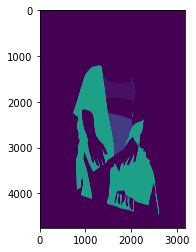

In [73]:
import matplotlib.pyplot as plt
plt.imshow(mask)

In [ ]:
[2, 34, 8, 26, 46]

In [74]:
import pandas as pd
pd.Series(mask.flatten()).unique()

array([ 0, 26,  2,  8, 34, 46], dtype=uint8)

In [25]:
mask.shape

(480, 640)

In [26]:
resized_mask.shape

(384, 480)

In [11]:
resized_image.shape

(384, 500, 3)

In [12]:
mask_small.shape

(384, 500)

In [10]:
pd.Series(mask_small.flatten()).unique()

array([ 0, 40], dtype=uint8)

In [21]:
file_name

'009e6233e876251fe60757a68ab3af30.jpg'

In [22]:
import matplotlib.pyplot as plt

In [23]:
resized_image = cv2.resize(mask, (480, 360), interpolation=cv2.INTER_NEAREST)

In [24]:
resized_image_real = cv2.resize(np.array(img_real), (480, 360), interpolation=cv2.INTER_NEAREST)

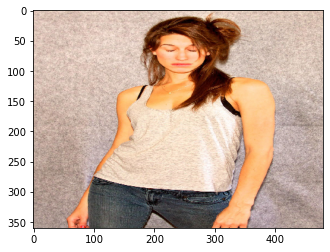

In [25]:
plt.imshow(resized_image_real)

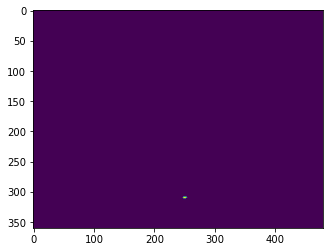

In [28]:
plt.imshow(mask_small)

In [16]:
pd.Series(mask.flatten()).unique()

array([ 0, 37], dtype=uint8)

In [17]:
dft

,ImageId,EncodedPixels,Height,Width,ClassId,ClassName
312541,fa5e67e901b8e4863491cc71757f6aa6.jpg,397499 1 398697 3 399896 4 401094 7 402293 8 4...,1200,800,37,applique


In [11]:
df.sort_values('ClassId').drop_duplicates(subset=['ClassId', 'ClassName']).ClassName

13460                               shirt, blouse
50396                    top, t-shirt, sweatshirt
150002                                    sweater
236071                                   cardigan
267469                                     jacket
301230                                       vest
187171                                      pants
231902                                     shorts
68796                                       skirt
180962                                       coat
240876                                      dress
54162                                    jumpsuit
250519                                       cape
129544                                    glasses
223777                                        hat
212133    headband, head covering, hair accessory
46339                                         tie
240129                                      glove
22267                                       watch
2819                                         belt


In [10]:
len(['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan',
       'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress',
       'jumpsuit', 'cape', 'glasses', 'hat',
       'headband, head covering, hair accessory', 'tie', 'glove', 'watch',
       'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe',
       'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel',
       'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper',
       'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet',
       'ruffle', 'sequin', 'tassel'])

46

In [12]:
df.drop_duplicates(subset=['ClassId', 'ClassName']).sort_values('ClassId').ClassName.values

array(['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan',
       'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress',
       'jumpsuit', 'cape', 'glasses', 'hat',
       'headband, head covering, hair accessory', 'tie', 'glove', 'watch',
       'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe',
       'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel',
       'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper',
       'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet',
       'ruffle', 'sequin', 'tassel'], dtype=object)

In [11]:
for i in ['bg', 'shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan',
       'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress',
       'jumpsuit', 'cape', 'glasses', 'hat',
       'headband, head covering, hair accessory', 'tie', 'glove', 'watch',
       'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe',
       'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel',
       'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper',
       'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet',
       'ruffle', 'sequin', 'tassel']:
    print(i)

bg
shirt, blouse
top, t-shirt, sweatshirt
sweater
cardigan
jacket
vest
pants
shorts
skirt
coat
dress
jumpsuit
cape
glasses
hat
headband, head covering, hair accessory
tie
glove
watch
belt
leg warmer
tights, stockings
sock
shoe
bag, wallet
scarf
umbrella
hood
collar
lapel
epaulette
sleeve
pocket
neckline
buckle
zipper
applique
bead
bow
flower
fringe
ribbon
rivet
ruffle
sequin
tassel
